In [5]:
# loading necessary libraries
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam, AdamW
from keras.utils import plot_model
import tensorboard
keras.utils.set_random_seed(844)

import pandas as pd
import geopandas as gpd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from joblib import dump, load
import pickle
import json
from rasterio import plot
import os

import ee
import geemap
import rasterio as rio
from tqdm.notebook import tqdm
from datetime import datetime

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from libs.ee_utils import Utilities as utils
from libs.ee_featuregeneration import FeatureGeneration
from libs.ee_utils import Utilities as utils

In [6]:
GEE_SERVICE_ACC = 'kjr-eej-jahid@ee-kazijahid.iam.gserviceaccount.com'
GEE_CREDS = "D:/3. Projects/dash/ds4rs_main_app/ee-kazijahid-f8bb3244119c.json"
collection_name = 'COPERNICUS/S2_SR_HARMONIZED'
mgrs_tile_no = '48PVT'
from_year = 2024
to_year = 2024
from_month = 1
to_month = 4
maximum_cloud = 2
dark_feature_percenatge = 2
selectedbands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']

# location of area of interest shape file in your storage
saving_dir = '2024'
band_saving_dir = f'./Data/{saving_dir}/Bands/'
plots_saving_dir = f'./Data/{saving_dir}/Plots/'
grids_saving_dir = f'./Data/{saving_dir}/Grids/'
best_model_saving_dir = f'./Data/{saving_dir}/Models/'
outputs_path = f'./Data/{saving_dir}/Outputs/'
aoi_path = "./Data/Inputs/MyAOI_32648.shp"
train_samples_path = "./Data/Inputs/TrainingData(Corrected)_2.shp"
test_samples_path = "./Data/Inputs/TestData(Corrected)_2.shp"

In [7]:
utils.loadEE(GEE_SERVICE_ACC, GEE_CREDS)


# If you do not have a GEE Credential, remove the above line and uncomment the below lines
# ee.Authenticate()
# # Initialize the library.
# ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')

'Authentication successful'

In [8]:
# Search the images from GEE archive
trainingImage, trainingImageprojection, trainingImagecrs, trainingImagetransform_image = utils.loadTrainingImage(collection_name, mgrs_tile_no, aoi_path, from_year, from_month, to_year, to_month, maximum_cloud, dark_feature_percenatge )

# To fill the cloud masked pixels
fillerImage = utils.loadFillerImage(collection_name, mgrs_tile_no, aoi_path, from_year, from_month, to_year, to_month, trainingImageprojection )

# Preprocessing
trainingImage = utils.preprocessImage(trainingImage, fillerImage)

#Clipping, Selecting Bands for aoi
trainingImage, trainingImageprojection, trainingImagecrs, trainingImagetransform  = utils.trimImage(trainingImage, aoi_path, selectedbands)
trainingImageID = trainingImage.id().getInfo()

# Creating the dirs
os.makedirs(band_saving_dir, exist_ok=True)
os.makedirs(plots_saving_dir, exist_ok=True)
os.makedirs(grids_saving_dir, exist_ok=True)
os.makedirs(best_model_saving_dir, exist_ok=True)
os.makedirs(outputs_path, exist_ok=True)

# Visualising the images
Map = geemap.Map()
Map.addLayer(trainingImage, {'bands':['B4', 'B3','B2'],'min':0, 'max':10000, 'gamma':[3,3,3]}, 'TrainingImage')
Map.centerObject(trainingImage.geometry())
Map

Image Used for filler image: 13
Preprocessing Completed. Returning the processed image...
Clipping and Band selection completed. Returning trimmed image


Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

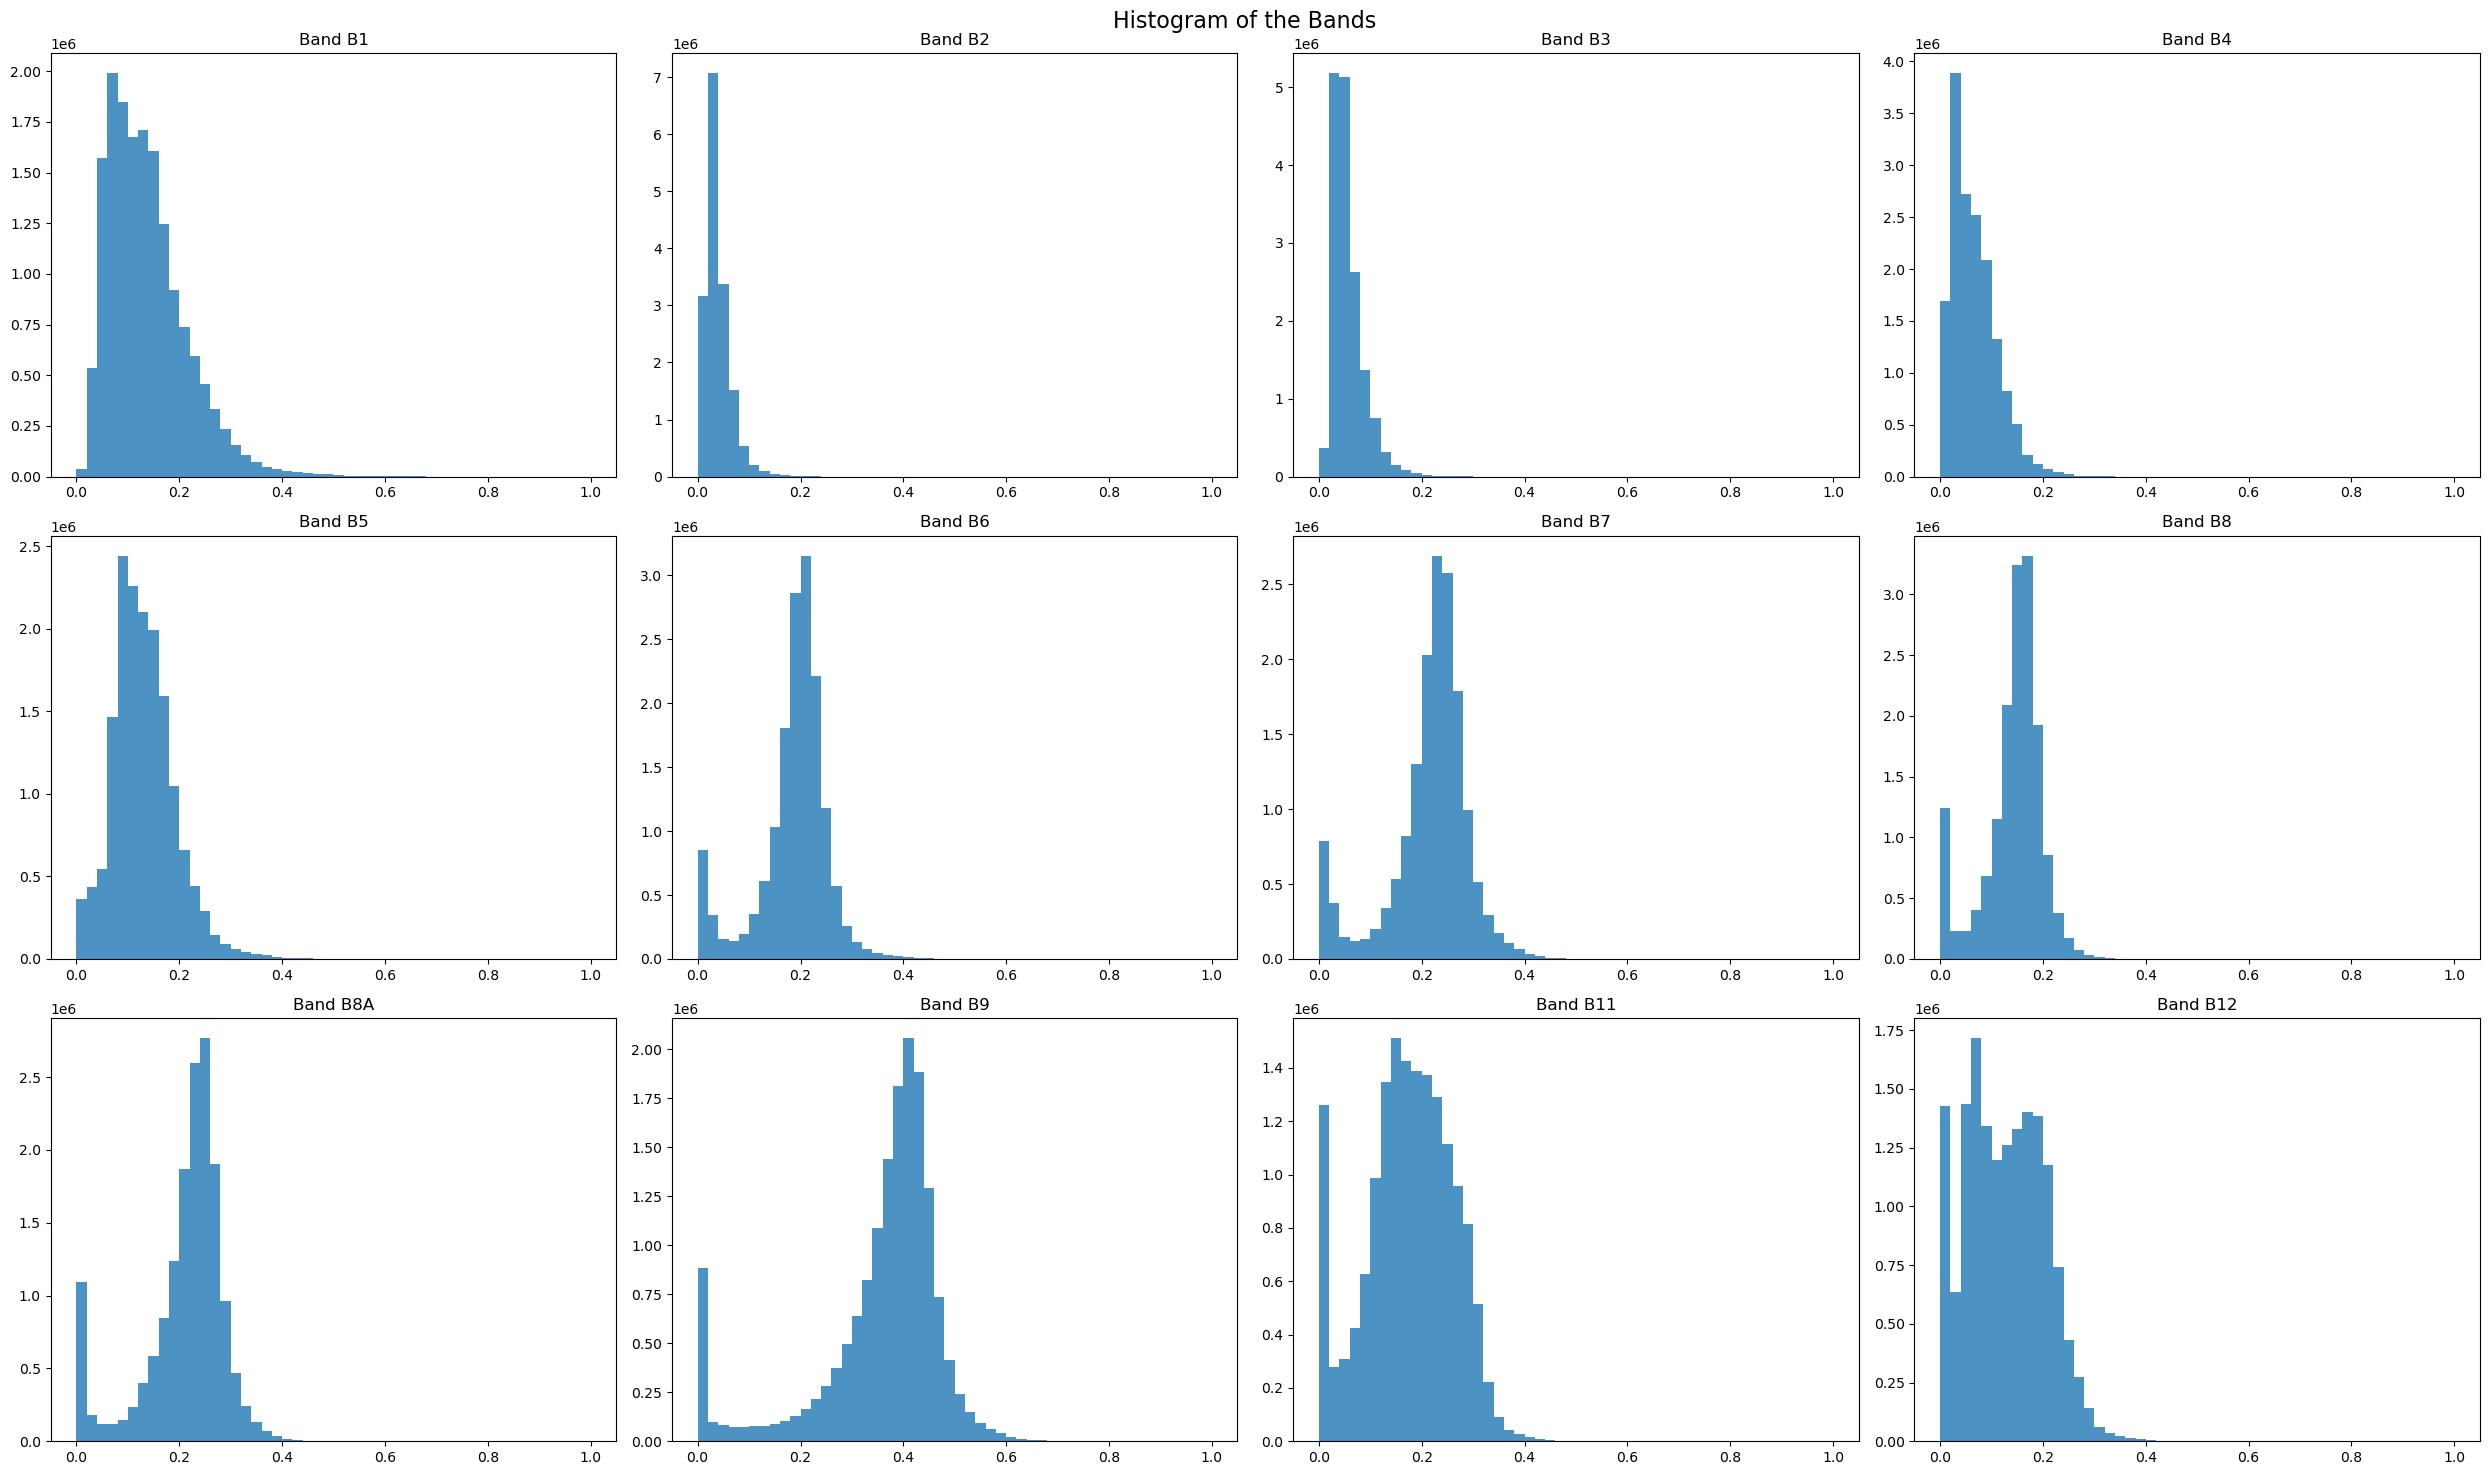

In [9]:
# Download data, to download uncomment the first line after this line
# exportedFolder = utils.downloadBands(trainingImage, selectedbands, aoi_path, band_saving_dir, 10)

exportedFolder = f'{band_saving_dir}/{trainingImageID}'
BandData, BandsAffineTransform, BandsCrs = utils.loadBands(export_path =exportedFolder, selectedbands = selectedbands )
# Normalizing the bands
BandData = utils.normalize(BandData)


# Plotting the normalized bands
num_bands = len(BandData)
num_rows = (num_bands + 3) // 4
fig, axs = plt.subplots(num_rows, 4, figsize=(25, 5 * num_rows))
selectedbands = selectedbands[:num_bands]  # Ensure that the number of selected bands is within the available bands

for idx, band in enumerate(selectedbands):
    band_array = BandData[idx]
    rowidx = idx // 4
    colidx = idx % 4
    ax = axs[rowidx, colidx]
    ax.hist(band_array.flatten(), bins=50, lw=0.0, stacked=False, alpha=0.8)
    ax.set_title(f"Band {band}")
    
if num_bands < num_rows * 4:
    for i in range(num_bands, num_rows * 4):
        axs.flatten()[i].axis('off')
plt.suptitle('Histogram of the Bands', fontsize=16)
plt.tight_layout()
plt.show()
fig.savefig(f"{plots_saving_dir}Bands_Histograms.png", bbox_inches='tight')

In [11]:
# Calculating the indices
ndbi = FeatureGeneration.functn_Ndbi(SWIR = BandData[10], NIR = BandData[7]) # in sentinel 2  B11 is SWIR and B8 is NIR,
ndwi = FeatureGeneration.functn_Ndwi(GREEN = BandData[2], NIR = BandData[7])  # in sentinel 2 B3 is Green and B8 is NIR
ndvi = FeatureGeneration.functn_Ndvi(NIR = BandData[7], RED = BandData[3])  # In Sentinel 2 B8 is NIR and B4 is Red
bsi = FeatureGeneration.functn_Bsi( BLUE =  BandData[1], RED =  BandData[3], NIR =  BandData[7], SWIR2 = BandData[11])

# Saving the caluclated indices
utils.save_geotiff(data = ndbi, crs = BandsCrs, transform=BandsAffineTransform, output_path=exportedFolder + "NDBI.tif")
utils.save_geotiff(data=ndwi, crs=BandsCrs, transform=BandsAffineTransform, output_path=exportedFolder + "NDWI.tif")
utils.save_geotiff(data=ndvi, crs=BandsCrs, transform= BandsAffineTransform, output_path=exportedFolder + "NDVI.tif")
utils.save_geotiff(data=bsi, crs=BandsCrs, transform=BandsAffineTransform, output_path=exportedFolder + "BSI.tif")

# Creating the final datasets, 2 datasets first with only bands, second with 4 extra indices
bandsDataNoIndex = np.asarray(BandData)
bandsDataNoIndex = np.nan_to_num(bandsDataNoIndex, nan=0.0, posinf=0.0, neginf=0.0)

bandsData4Index = np.asarray(BandData+[ndbi,ndwi,ndvi,bsi])
bandsData4Index = np.nan_to_num(bandsData4Index, nan=0.0, posinf=0.0, neginf=0.0)
selectedbands = selectedbands+['NDBI','NDWI','NDVI','BSI']

# Load spectral values for all training and testing samples
trainingDataset, trainingData, trainingLabel = utils.loadTrainTestData(bandsData4Index, selectedbands,  train_samples_path, BandsAffineTransform, BandsCrs)
testingDataset, testingData, testingLabel = utils.loadTrainTestData(bandsData4Index, selectedbands,  test_samples_path, BandsAffineTransform, BandsCrs)

100%|██████████████████████████████████████████████████████████████████████████████| 800/800 [00:00<00:00, 5357.01it/s]


In [12]:
# Preparing the dataset and labels for the model
trainDataNoIndice=[]
trainLabelNoIndice=[]
testDataNoIndice=[]
testLabelNoIndice=[]

trainData4Indice=[]
trainLabel4Indice=[]
testData4Indice=[]
testLabel4Indice=[]
NumOfClasses=len(testingDataset.c_number.unique())

for i in range(NumOfClasses):
    training_Data_class_i_NoIndice=trainingDataset[trainingDataset["c_number"]==i][['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12']].values
    training_Labels_class_i_NoIndice=trainingDataset[trainingDataset["c_number"]==i]["c_number"]
   
    training_Data_class_i_4Indice=trainingDataset[trainingDataset["c_number"]==i][['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12','NDBI','NDWI','NDVI','BSI']].values
    training_Labels_class_i_4Indice=trainingDataset[trainingDataset["c_number"]==i]["c_number"]

    testing_Data_class_i_NoIndice=testingDataset[testingDataset["c_number"]==i][['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12']].values
    testing_Labels_class_i_NoIndice=testingDataset[testingDataset["c_number"]==i]["c_number"]

    testing_Data_class_i_4Indice=testingDataset[testingDataset["c_number"]==i][['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12','NDBI','NDWI','NDVI','BSI']].values
    testing_Labels_class_i_4indice=testingDataset[testingDataset["c_number"]==i]["c_number"]


    trainDataNoIndice.extend(training_Data_class_i_NoIndice)
    trainLabelNoIndice.extend(training_Labels_class_i_NoIndice)
    testDataNoIndice.extend(testing_Data_class_i_NoIndice)
    testLabelNoIndice.extend(testing_Labels_class_i_NoIndice)

    trainData4Indice.extend(training_Data_class_i_4Indice)
    trainLabel4Indice.extend(training_Labels_class_i_4Indice)
    testData4Indice.extend(testing_Data_class_i_4Indice)
    testLabel4Indice.extend(testing_Labels_class_i_4indice)

    print('Class',i)
    print(f'Training Data-Label No Indices Shape {training_Data_class_i_NoIndice.shape}, {training_Labels_class_i_NoIndice.shape}')
    print(f'Testing Data-Label No Indices Shape {testing_Data_class_i_NoIndice.shape} , {testing_Labels_class_i_NoIndice.shape, }')

    print(f'Training Data-Label 4 Indices Shape {training_Data_class_i_4Indice.shape}, {training_Labels_class_i_4Indice.shape}')
    print(f'Testing Data-Label 4 Indices Shape {testing_Data_class_i_4Indice.shape} , {testing_Labels_class_i_4indice.shape, }')

trainDataNoIndice=np.array(trainDataNoIndice)
testDataNoIndice=np.array(testDataNoIndice)
trainLabelNoIndice=np.array(trainLabelNoIndice)
testLabelNoIndice=np.array(testLabelNoIndice)

trainData4Indice=np.array(trainData4Indice)
testData4Indice=np.array(testData4Indice)
trainLabel4Indice=np.array(trainLabel4Indice)
testLabel4Indice=np.array(testLabel4Indice)

# Shuffle the data while maintaining correspondence
trainDataNoIndice, trainLabelNoIndice = shuffle(trainDataNoIndice, trainLabelNoIndice, random_state=6)
testDataNoIndice, testLabelNoIndice = shuffle(testDataNoIndice, testLabelNoIndice, random_state=6)

trainData4Indice, trainLabel4Indice = shuffle(trainData4Indice, trainLabel4Indice, random_state=6)
testData4Indice, testLabel4Indice = shuffle(testData4Indice, testLabel4Indice, random_state=6)

Class 0
Training Data-Label No Indices Shape (306, 12), (306,)
Testing Data-Label No Indices Shape (117, 12) , ((117,),)
Training Data-Label 4 Indices Shape (306, 16), (306,)
Testing Data-Label 4 Indices Shape (117, 16) , ((117,),)
Class 1
Training Data-Label No Indices Shape (308, 12), (308,)
Testing Data-Label No Indices Shape (104, 12) , ((104,),)
Training Data-Label 4 Indices Shape (308, 16), (308,)
Testing Data-Label 4 Indices Shape (104, 16) , ((104,),)
Class 2
Training Data-Label No Indices Shape (321, 12), (321,)
Testing Data-Label No Indices Shape (117, 12) , ((117,),)
Training Data-Label 4 Indices Shape (321, 16), (321,)
Testing Data-Label 4 Indices Shape (117, 16) , ((117,),)
Class 3
Training Data-Label No Indices Shape (308, 12), (308,)
Testing Data-Label No Indices Shape (131, 12) , ((131,),)
Training Data-Label 4 Indices Shape (308, 16), (308,)
Testing Data-Label 4 Indices Shape (131, 16) , ((131,),)
Class 4
Training Data-Label No Indices Shape (393, 12), (393,)
Testing D

**Training and Fitting Model - SVM**

**Training and Fitting Model - Random Forest**

**Training and Fitting Model - ANN**

In [13]:
# Neural Network
trainData_ANN_NoIndice = np.array(trainDataNoIndice)
testData_ANN_NoIndice = np.array(testDataNoIndice)
trainLabel_ANN_NoIndice = keras.utils.to_categorical(trainLabelNoIndice)
testLabel_ANN_NoIndice = keras.utils.to_categorical(testLabelNoIndice)
trainData_ANN_4Indice = np.array(trainData4Indice)
testData_ANN_4Indice = np.array(testData4Indice)
trainLabel_ANN_4Indice = keras.utils.to_categorical(trainLabel4Indice)
testLabel_ANN_4Indice = keras.utils.to_categorical(testLabel4Indice)

EarlyStopping_CB = EarlyStopping(monitor='val_accuracy', mode='max', patience=300, min_delta=0.001, verbose=0)

def modelCreate(train_data_nn, train_label_nn):
    
    model = Sequential()
    model.add(Dense(12, input_dim=train_data_nn.shape[1]))
    model.add(Dense(16, activation=LeakyReLU(alpha=0.3)))
    model.add(Dense(32, activation=LeakyReLU(alpha=0.3)))
    model.add( Dropout(0.2) )
    model.add(Dense(64, activation=LeakyReLU(alpha=0.3)))
    model.add( Dropout(0.2) )
    model.add(Dense(len(train_label_nn[0]), activation="softmax"))

    optimizer = AdamW(learning_rate=0.015)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])    
 
    return model

In [ ]:
# '''Training the ANN model for No Indices. To run uncomment below lines. Beaware it is time consuming'''
# logDirNoIndices = f"{saving_dir}logs/Fit_NoIndices/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# Tensorboard_Callback_NoIndices = keras.callbacks.TensorBoard(log_dir=logDirNoIndices)

# CheckPoint_CB_NoIndices = ModelCheckpoint(filepath=f"{logDirNoIndices}checkpoints/model_{epoch:02d}_{loss:.3f}_{val_accuracy:.3f}.h5",
#     monitor="val_accuracy", save_best_only=True, save_weights_only=False, mode="max", verbose=1, initial_value_threshold=0.85,)

# ANN_NoIndicesModel = modelCreate(trainData_ANN_NoIndice, trainLabel_ANN_NoIndice)
# historyANN_NoIndicesModel= ANN_NoIndicesModel.fit(x=trainData_ANN_NoIndice, y=trainLabel_ANN_NoIndice,epochs=1000, batch_size=64,
#                                                   validation_split=0.5, verbose=2, shuffle = True, callbacks=[CheckPoint_CB_NoIndices,  EarlyStopping_CB, Tensorboard_Callback_NoIndices])

# ANN_NoIndicesLoss, ANN_NoIndicesAcc = ANN_NoIndicesModel.evaluate(testData_ANN_NoIndice, testLabel_ANN_NoIndice)
# print("NoIndices - Loss: {:.4f}, Accuracy: {:.4f}".format(ANN_NoIndicesLoss, ANN_NoIndicesAcc))
# ANN_NoIndicesModel.save(f'./{logDirNoIndices}/{logDirNoIndices.split("/")[-1]}_{str(ANN_NoIndicesAcc).replace(".", "")}.h5')
# with open(f'./{logDirNoIndices}/{logDirNoIndices.split("/")[-1]}_History_{str(ANN_NoIndicesAcc).replace(".", "")}', 'wb') as history_file:
#     pickle.dump(historyANN_NoIndicesModel.history, history_file)
# print(logDirNoIndices)

# '''Training the ANN model for 4 Indices. To run uncomment below lines. Beaware it is time consuming'''
# logDir4Indices = f"{saving_dir}logs/Fit_4Indices/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# Tensorboard_Callback_4Indices = keras.callbacks.TensorBoard(log_dir=logDir4Indices)
# CheckPoint_CB_4Indices = ModelCheckpoint(
#     filepath="./"+logDir4Indices+"/checkpoints/model_{epoch:02d}_{val_loss:.3f}_{val_accuracy:.3f}.h5",
#     monitor="val_accuracy", save_best_only=True, save_weights_only=False, mode="max", verbose=1,initial_value_threshold=0.85)


# ANN_4IndicesModel = modelCreate(trainData_ANN_4Indice, trainLabel_ANN_4Indice)
# historyANN_4IndicesModel = ANN_4IndicesModel.fit(x=trainData_ANN_4Indice, y=trainLabel_ANN_4Indice, epochs=1000,
#                                                  batch_size=64, verbose=2, validation_split=0.5, shuffle = True,
#                                                  callbacks=[CheckPoint_CB_4Indices, EarlyStopping_CB, Tensorboard_Callback_4Indices])

# ANN_4IndicesLoss, ANN_4IndicesAcc = ANN_4IndicesModel.evaluate(testData_ANN_4Indice, testLabel_ANN_4Indice)
# print("4Indices - Loss: {:.4f}, Accuracy: {:.4f}".format(ANN_4IndicesLoss, ANN_4IndicesAcc))

# ANN_4IndicesModel.save(f'./{logDir4Indices}/{logDir4Indices.split("/")[-1]}_{str(ANN_4IndicesAcc).replace(".", "")}.h5')
# with open(f'./{logDir4Indices}/{logDir4Indices.split("/")[-1]}_History_{str(ANN_4IndicesAcc).replace(".", "")}', 'wb') as history_file:
#     joblib.dump(historyANN_4IndicesModel.history, history_file)
# print(logDir4Indices)

# Saving the models to Model directory for finding easily
# ANN_NoIndicesModel.save('./Data/Models/ANN_WithNoIndices_Model'+str(ANN_NoIndicesAcc).replace('.','')+'.h5')
# ANN_4IndicesModel.save('./Data/Models/ANN_With4Indices_Model'+str(ANN_4IndicesAcc).replace('.','')+'.h5')

# # Plotting the model structures
# plot_model(ANN_NoIndicesModel,to_file=f'{plots_saving_dir}modelANNNoIndices.png',show_shapes=True,show_dtype=False,show_layer_names=True,
#     rankdir='TB', expand_nested=True, dpi=300,layer_range=None,show_layer_activations=True,show_trainable=True)

# plot_model(ANN_4IndicesModel,to_file=f'{plots_saving_dir}modelANN4Indices.png',show_shapes=True,show_dtype=False,show_layer_names=True,
#     rankdir='TB',expand_nested=True,
#     dpi=300,layer_range=None,show_layer_activations=True,show_trainable=True)

# # Load the TensorBoards for monitoring the model trainings. Open One at a time. Or run below sections in 2 different cells
# # For No Indices
# %load_ext tensorboard
# %reload_ext tensorboard
# %tensorboard --logdir logs/Fit_NoIndices --port=8801

# # For 4 Indices 
# %load_ext tensorboard
# %reload_ext tensorboard
# %tensorboard --logdir logs/Fit_4Indices --port=8813

In [ ]:
# '''Loading pretrained models and calculating accuracies'''

# model_path = "logs/Fit_NoIndices/20240223-090505/checkpoints/model_401_0.310_0.881.h5"
# Loaded_ANN_NoIndicesModel = keras.models.load_model(model_path)
# # ANN_NoIndicesLoss, ANN_NoIndicesAcc =Loaded_ANN_NoIndicesModel.evaluate(testData_ANN_NoIndice,testLabel_ANN_NoIndice)
# # print("NoIndices - Loss: {:.4f}, Accuracy: {:.4f}".format(ANN_NoIndicesLoss, ANN_NoIndicesAcc ))

# model_path_ANN4Indices = "./logs/Fit_4Indices/20240223-091211/checkpoints/model_642_0.398_0.888.h5"
# Loaded_ANN_4IndicesModel = keras.models.load_model(model_path_ANN4Indices)
# # ANN_4IndicesLoss, ANN_4IndicesAcc =Loaded_ANN_4IndicesModel.evaluate(testData_ANN_4Indice,testLabel_ANN_4Indice)
# # print("4Indices - Loss: {:.4f}, Accuracy: {:.4f}".format(ANN_4IndicesLoss, ANN_4IndicesAcc ))

# with open('./logs/Fit_NoIndices/20240223-090505/20240223-090505_History_084375', "rb") as historyfile:
#     Loaded_ANN_NoIndicesModelHist = load(historyfile)

# with open('./logs/Fit_4Indices/20240223-091211/20240223-091211_History_08487499952316284', "rb") as historyfile:
#     Loaded_ANN_4IndicesModelHist = load(historyfile)

# ANN_NoIndicesLoss, ANN_NoIndicesAcc =Loaded_ANN_NoIndicesModel.evaluate(testData_ANN_NoIndice,testLabel_ANN_NoIndice)
# print("NoIndices - Loss: {:.4f}, Accuracy: {:.4f}".format(ANN_NoIndicesLoss, ANN_NoIndicesAcc ))
# ANN_4IndicesLoss, ANN_4IndicesAcc =Loaded_ANN_4IndicesModel.evaluate(testData_ANN_4Indice,testLabel_ANN_4Indice)
# print("4Indices - Loss: {:.4f}, Accuracy: {:.4f}".format(ANN_4IndicesLoss, ANN_4IndicesAcc ))

# TestPrediction_ANNModelWithNoIndices = np.argmax(Loaded_ANN_NoIndicesModel.predict(testData_ANN_NoIndice), axis=-1)
# TestPrediction_ANNModelWith4Indices = np.argmax(Loaded_ANN_4IndicesModel.predict(testData_ANN_4Indice), axis=-1)

# # labels = ['TreeFloodedOtherVegi','RoadsOtherImpervious','Grassland','Building','Water', 'Agriculture', 'BareLand']

# print('\t\n Classification Report for ANN NoIndice')
# print(classification_report(np.argmax(testLabel_ANN_NoIndice, axis=-1), TestPrediction_ANNModelWithNoIndices,  target_names=labels))

# print('\t\n Classification Report for ANN 4Indice')
# print(classification_report(np.argmax(testLabel_ANN_4Indice, axis=-1), TestPrediction_ANNModelWith4Indices,  target_names=labels))


# '''Train and Validation Curves. It can also be found on tensorboard'''
# Loaded_ANN_NoIndicesModelHist_Accs = Loaded_ANN_NoIndicesModelHist['accuracy']
# Loaded_ANN_NoIndicesModelHist_epochs = range(1, len(Loaded_ANN_NoIndicesModelHist_Accs) + 1)
# Loaded_ANN_NoIndicesModelHist_ValAccs = Loaded_ANN_NoIndicesModelHist['val_accuracy']
# Loaded_ANN_NoIndicesModelHist_losses = Loaded_ANN_NoIndicesModelHist['loss']
# Loaded_ANN_NoIndicesModelHist_ValLosses = Loaded_ANN_NoIndicesModelHist['val_loss']

# Loaded_ANN_4IndicesModelHist_Accs = Loaded_ANN_4IndicesModelHist['accuracy']
# Loaded_ANN_4IndicesModelHist_epochs = range(1, len(Loaded_ANN_4IndicesModelHist_Accs) + 1)
# Loaded_ANN_4IndicesModelHist_ValAccs = Loaded_ANN_4IndicesModelHist['val_accuracy']
# Loaded_ANN_4IndicesModelHist_losses = Loaded_ANN_4IndicesModelHist['loss']
# Loaded_ANN_4IndicesModelHist_ValLosses = Loaded_ANN_4IndicesModelHist['val_loss']

# # Plot training accuracy and validation accuracy, No Indices
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.plot(Loaded_ANN_NoIndicesModelHist_epochs, Loaded_ANN_NoIndicesModelHist_Accs, 'y', label='Training accuracy')
# plt.plot(Loaded_ANN_NoIndicesModelHist_epochs, Loaded_ANN_NoIndicesModelHist_ValAccs, 'r', label='Validation accuracy')
# plt.title('Train and Val Accs of ANN NoIndices')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# # Plot training accuracy and validation accuracy, 4 Indices
# plt.subplot(1, 2, 2)
# plt.plot(Loaded_ANN_4IndicesModelHist_epochs, Loaded_ANN_4IndicesModelHist_Accs, 'y', label='Training accuracy')
# plt.plot(Loaded_ANN_4IndicesModelHist_epochs, Loaded_ANN_4IndicesModelHist_ValAccs, 'r', label='Validation accuracy')
# plt.title('Train and Val Accs of ANN 4Indices')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.tight_layout()
# plt.savefig(f'{plots_saving_dir}ANN Train and Val Accs.png', dpi= 300)
# plt.show()

# # Plot training loss and validation loss, No Indices
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.plot(Loaded_ANN_NoIndicesModelHist_epochs, Loaded_ANN_NoIndicesModelHist_losses, 'b', label='Training loss')
# plt.plot(Loaded_ANN_NoIndicesModelHist_epochs, Loaded_ANN_NoIndicesModelHist_ValLosses, 'g', label='Validation loss')
# plt.title('Train and Val Loss of ANN NoIndices')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# # Plot training loss and validation loss, 4 Indices
# plt.subplot(1, 2, 2)
# plt.plot(Loaded_ANN_4IndicesModelHist_epochs, Loaded_ANN_4IndicesModelHist_losses, 'b', label='Training loss')
# plt.plot(Loaded_ANN_4IndicesModelHist_epochs, Loaded_ANN_4IndicesModelHist_ValLosses, 'g', label='Validation loss')
# plt.title('Train and Val Loss of ANN 4Indices')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.tight_layout()
# plt.savefig(f'{plots_saving_dir}ANN Train and Val Loss.png', dpi=300)
# plt.show()

# # Generating the confusion matrices
# ConfusionMatrix_ANN_NoIndices = confusion_matrix(np.argmax(testLabel_ANN_NoIndice, axis=-1), TestPrediction_ANNModelWithNoIndices)
# ConfusionMatrix_ANN_4Indices = confusion_matrix(np.argmax(testLabel_ANN_4Indice, axis=-1), TestPrediction_ANNModelWith4Indices)
# # Plot each confusion matrix
# fig, axs = plt.subplots(1, 2, figsize=(14, 7))
# ConfusionMatrixDisplay(confusion_matrix=ConfusionMatrix_ANN_NoIndices, display_labels=labels).plot(ax=axs[0], xticks_rotation=90)
# axs[0].set_title('ANN Confusion Matrix NoIndices')
# ConfusionMatrixDisplay(confusion_matrix=ConfusionMatrix_ANN_4Indices, display_labels=labels).plot(ax=axs[1], xticks_rotation=90)
# axs[1].set_title('ANN Confusion Matrix 4Indices')
# plt.tight_layout()
# plt.show()
# fig.savefig(f'{plots_saving_dir}ANN Confusion Matrix', dpi=300)

# # Class and Indices Whisker plot to explain the relationship
# filtered_data = trainingDataset[['NDBI', 'NDWI', 'NDVI', 'BSI', 'c_number']]
# fig, axes = plt.subplots(2, 2, figsize=(15, 10))
# axes = axes.flatten()
# for i, column in enumerate(['NDBI', 'NDWI', 'NDVI', 'BSI']):
#     sns.boxplot(x='c_number', y=column, data=filtered_data, ax=axes[i])
#     axes[i].set_title(f"{column} vs. Land Classes")
# plt.tight_layout()
# plt.savefig(f'{plots_saving_dir}Class-IndicesWhisker', dpi=300)
# plt.show()

In [ ]:
'''Classify the complete image and save. Beaware it is time consuming'''
# tf.keras.utils.disable_interactive_logging()
# imgPrediction_ANN_NoIndices = utils.imagePrediction(Loaded_ANN_NoIndicesModel, bandsDataNoIndex, 'ANN')
# imgPrediction_ANN_4Indices = utils.imagePrediction(Loaded_ANN_4IndicesModel, bandsData4Index, 'ANN')

# allANNImages = {'NoIndices': imgPrediction_ANN_NoIndices,'4Indices': imgPrediction_ANN_4Indices}
# for name, annimage in allANNImages.items():
#     # Define the output file path based on the model name
#     OutputFilePath_RF = f"{outputs_path}ANN_{name}_classified.tif"
#     with rio.open(OutputFilePath_RF, 'w', driver='GTiff', width=annimage.shape[1],
#                   height=annimage.shape[0], count=1, crs=BandsCrs,
#                   transform=BandsAffineTransform, dtype=np.uint8) as output:
#         output.write(annimage, 1)
#     Image.fromarray(255*(annimage==2).astype(np.uint8)).show()

**Hybrid Selection based on F1 Score Voting Voting**